In [1]:
from numpy import asarray
from sklearn.datasets import make_regression
from keras.models import Sequential

import keras
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
import tensorflow as tf

# evaluate a model using repeated k-fold cross-validation
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.utils.vis_utils import plot_model
import scipy as sp
import time
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure

from multiprocessing import Pool
from joblib import Parallel, delayed

data_path = '/nethome/yuxiang.wu/Dataset_Cleaned/'

2023-03-10 17:33:40.125887: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 17:33:42.642312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/miniconda3/envs/tf-env/lib/
2023-03-10 17:33:42.642512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/miniconda3/envs/tf-env/lib/
2023-03-10 17:33:42.642536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please m

### Use GPU or not


In [2]:
# # check the availablity of all GPU machiens
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)


# # select first GPU machine
# tf.config.set_visible_devices(gpus[1], 'GPU')
# logical_gpus = tf.config.list_logical_devices('GPU')

# # verify the setup
# logical_gpus = tf.config.list_logical_devices('GPU')
# print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

# not using GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Import hardness training dataset


In [3]:
# define an empty df with column head defined
df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
                                 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

# import Hardness dataset
df_H = pd.read_excel(data_path + 'Hardness_database_YW_v3.xlsx', header=2)

print(df_H.columns)

# obtain the 2 inputs and 1 output from this dataset
df_H_compo = pd.concat([df_compo, df_H[['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
                                        'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']]], axis=0, ignore_index=True)
df_H_compo = df_H_compo.fillna(0)  # fill in the nan by zero

df_H_specific = df_H[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]
df_H_output = df_H['converted HV']

# df_H_compo.to_excel('checkcheck.xlsx')
print(df_H_compo.shape, df_H_specific.shape, df_H_output.shape)


# df_H_compo['Al'] = 0
# display(np.mean(df_H_compo['Al'].values))

Index(['Alloy ID', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf', 'delta_a',
       'Hmix', 'VEC', 'sigma_bulk_modulus', 'converted HV'],
      dtype='object')
(680, 20) (680, 4) (680,)


0.0

### Import corrosion training dataset


In [4]:
# import corrosion dataset
df_C = pd.read_excel(data_path + 'Corrosion_database_YW_v3.xlsx', header=2)

print(df_C.columns)

# obtain the 2 inputs and 1 output from this dataset
df_C_compo = pd.concat([df_compo, df_C[['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
                                        'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y']]], axis=0, ignore_index=True)
df_C_compo = df_C_compo.fillna(0)  # fill in the nan by zero

df_C_specific = df_C[['TestTemperature_C',
                      'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']]
df_C_output = df_C['AvgPittingPotential_mV']

# df_C_compo.to_excel('checkcheck.xlsx')

print(df_C_compo.shape, df_C_specific.shape, df_C_output.shape)


# df_C_compo['Al'] = 0

Index(['Alloy ID', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'TestTemperature_C',
       'ChlorideIonConcentration', 'pH', 'ScanRate_mVs',
       'AvgPittingPotential_mV'],
      dtype='object')
(712, 20) (712, 4) (712,)


### Data preprocessing of datasets

#### hardness network:

- input (X1): df_H_compo
- input (Y1): df_H_specific
- output(H1): df_H_output

#### corrosion network

- input (X2): df_C_compo
- input (Z2): df_C_specific
- output(C2): df_C_output

#### obtain the MinMaxScaler from normalisation


In [5]:
# prepare inputs and outputs for NN
dfs = [df_H_compo, df_H_specific, df_H_output,
       df_C_compo, df_C_specific, df_C_output]
inputs_outputs = [np.asarray(df.values) for df in dfs]

# assign variables
X1, Y1, H1, X2, Z2, C2 = inputs_outputs

# create the scalar
scaler_compo = MinMaxScaler()  # for input compo
scaler_H_specific = MinMaxScaler()  # for input H specific
scaler_C_specific = MinMaxScaler()  # for input H specific
scaler_output = MinMaxScaler()  # for all outputs

scaler_compo.fit(np.concatenate((X1, X2)))
scaler_H_specific.fit(Y1)
scaler_C_specific.fit(Z2)
scaler_output.fit(np.concatenate((H1, C2)).reshape((-1, 1)))


# X1= scaler_compo.transform(X1)
# Y1= scaler_H_specific.transform(Y1)
# H1= scaler_output.transform(H1.reshape((-1,1)))

MinMaxScaler()

### Feature importance scrore

#### hardness network:

- input (X1) - output(H1)

#### corrosion network

- input (X2) - output(C2)


In [6]:
print(X1.shape, H1.shape)
print(X2.shape, C2.shape)

(680, 20) (680,)
(712, 20) (712,)


In [7]:
from sklearn.ensemble import RandomForestRegressor

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_H = RandomForestRegressor(random_state=0)
forest_C = RandomForestRegressor(random_state=0)

forest_H.fit(X1, H1)
forest_C.fit(X2, C2)

RandomForestRegressor(random_state=0)

In [8]:
importances_H = forest_H.feature_importances_
importances_H

importances_C = forest_C.feature_importances_
importances_C

array([1.16644064e-01, 3.60028851e-01, 5.65344119e-02, 2.66829404e-01,
       6.58051021e-03, 3.19572374e-02, 2.62148813e-02, 2.67189260e-02,
       5.34601236e-02, 2.71655430e-02, 1.49161942e-02, 0.00000000e+00,
       3.88818429e-04, 4.75740501e-03, 5.05652148e-03, 2.69064301e-03,
       1.01085111e-05, 4.63570157e-05, 0.00000000e+00, 0.00000000e+00])

In [9]:
print(forest_H.score(X1, H1))

print(forest_C.score(X2, C2))

0.8789796086182928
0.8879876380181114


In [10]:
feature_names = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
                 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']

std_H = np.std(
    [tree.feature_importances_ for tree in forest_H.estimators_], axis=0)

std_C = np.std(
    [tree.feature_importances_ for tree in forest_C.estimators_], axis=0)

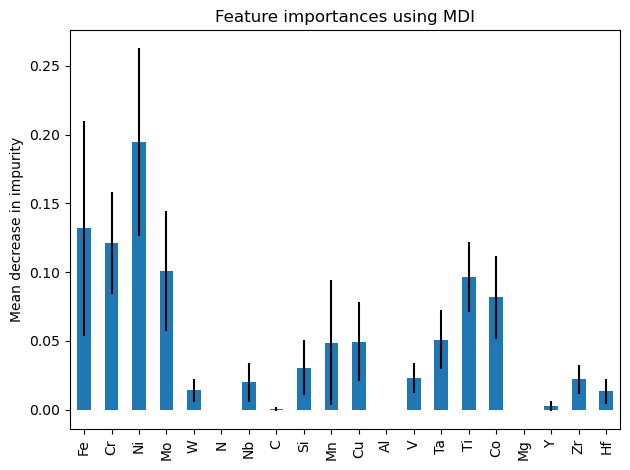

In [11]:
forest_importances_H = pd.Series(importances_H, index=feature_names)

fig, ax = plt.subplots()
forest_importances_H.plot.bar(yerr=std_H, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

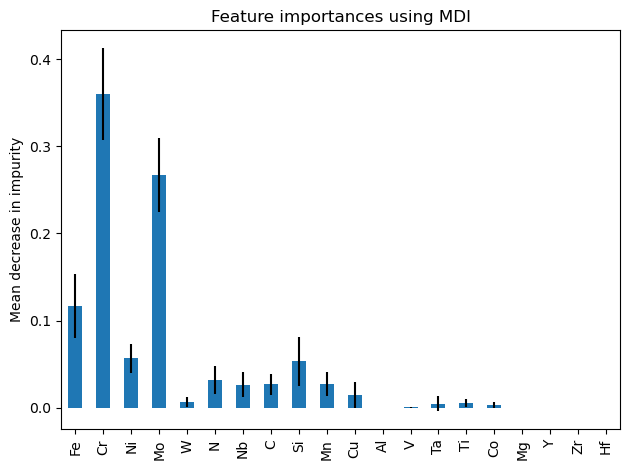

In [12]:
forest_importances_C = pd.Series(importances_C, index=feature_names)

fig, ax = plt.subplots()
forest_importances_C.plot.bar(yerr=std_C, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### RepeatedKFold

`X1_train_KFold`, `X1_test_KFold`, `Y1_train_KFold`, `Y1_test_KFold` , `H1_train_KFold`, `H1_test_KFold` as lists used in model training


/tmp/ipykernel_910324/2324119193.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_1 = cm.get_cmap('Blues', 10)
/tmp/ipykernel_910324/2324119193.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_2 = cm.get_cmap('Reds',  10)


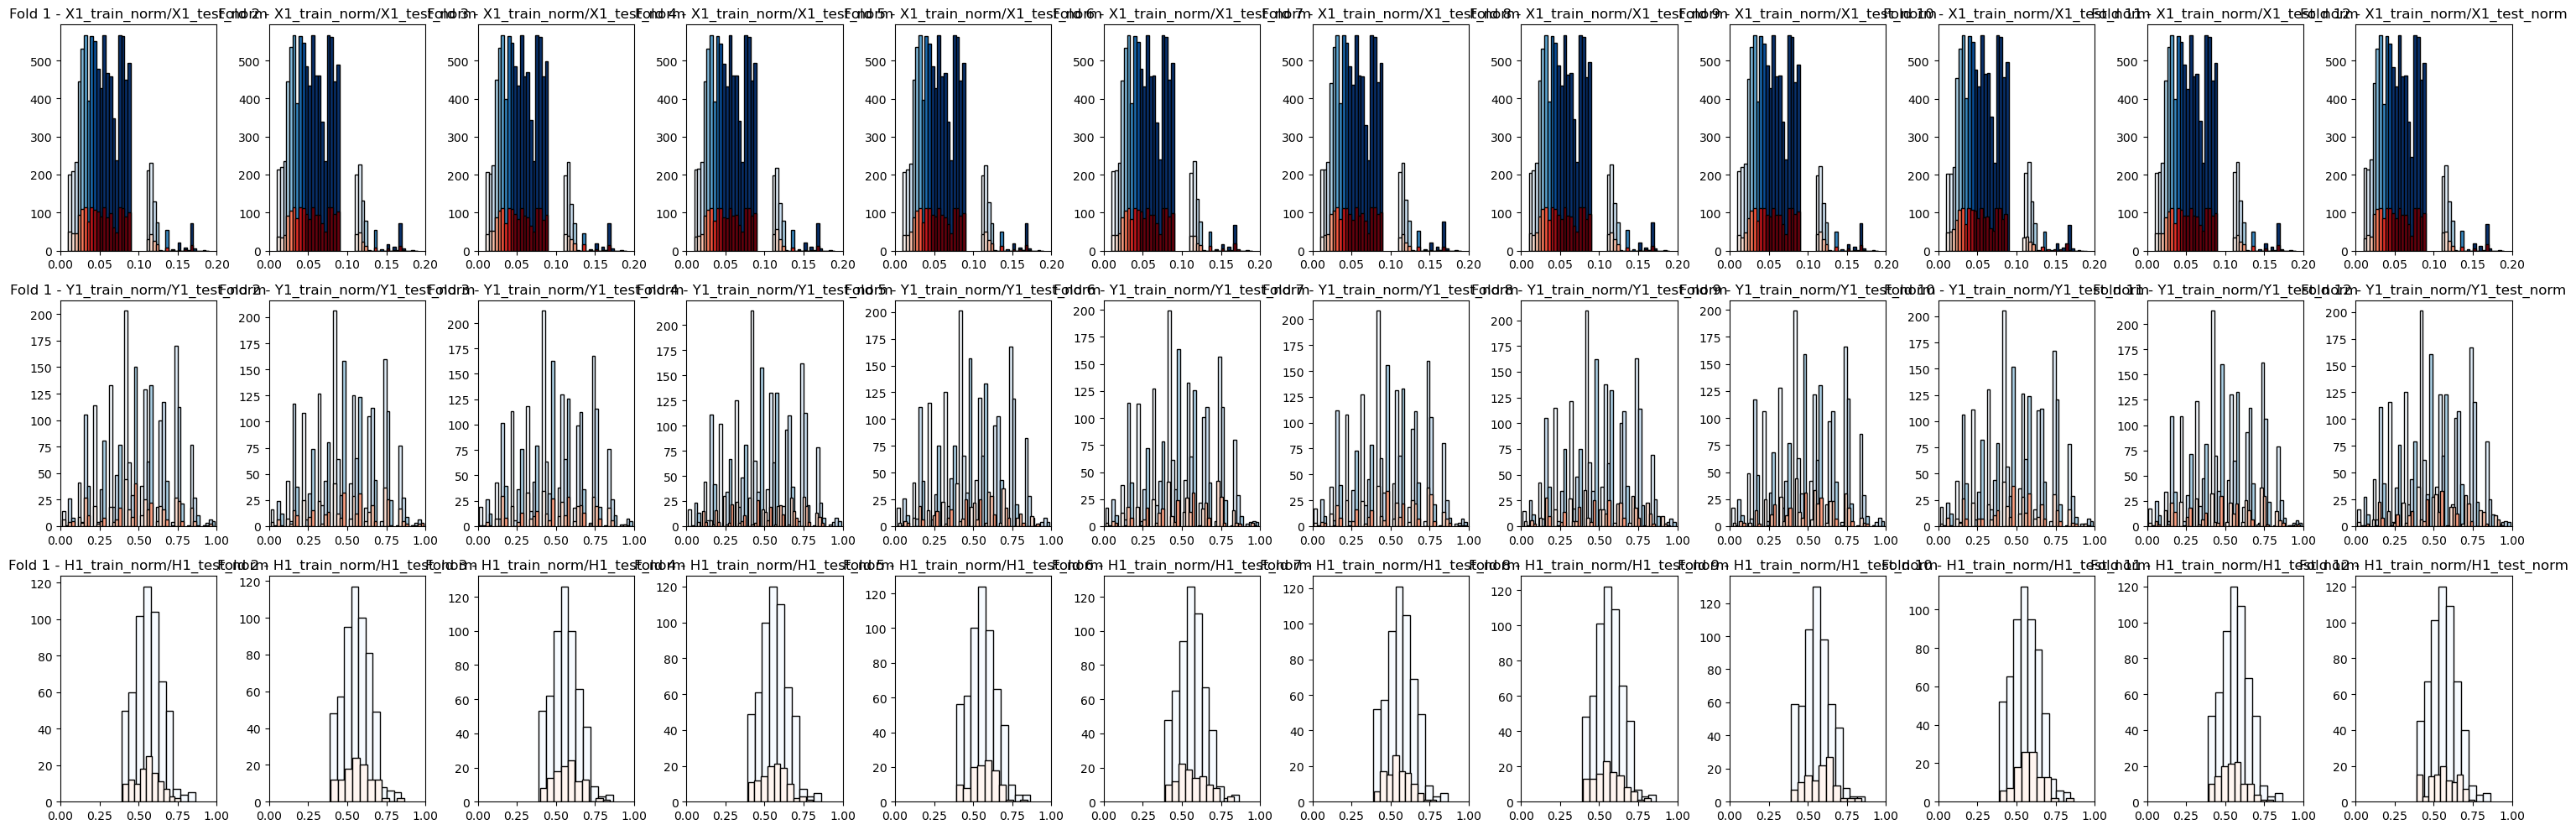

In [13]:
# define evaluation procedure
cv = RepeatedKFold(n_splits=6,
                   n_repeats=2,
                   random_state=42)

# create figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=12, figsize=(30, 10))

colors_1 = cm.get_cmap('Blues', 10)
colors_2 = cm.get_cmap('Reds',  10)

X1_train_KFold = []
X1_test_KFold = []
Y1_train_KFold = []
Y1_test_KFold = []
H1_train_KFold = []
H1_test_KFold = []

# enumerate folds*repeats
for i, (train_ix, test_ix) in enumerate(cv.split(X1)):

    # train-test split
    X1_train, X1_test = X1[train_ix], X1[test_ix]
    Y1_train, Y1_test = Y1[train_ix], Y1[test_ix]
    H1_train, H1_test = H1[train_ix], H1[test_ix]

    X1_train_KFold.append(X1_train)
    X1_test_KFold.append(X1_test)
    Y1_train_KFold.append(Y1_train)
    Y1_test_KFold.append(Y1_test)
    H1_train_KFold.append(H1_train)
    H1_test_KFold.append(H1_test)

    # MinMaxScaler normalisation
    X1_train_norm = scaler_compo.transform(X1_train)
    X1_test_norm = scaler_compo.transform(X1_test)
    Y1_train_norm = scaler_H_specific.transform(Y1_train)
    Y1_test_norm = scaler_H_specific.transform(Y1_test)
    H1_train_norm = scaler_output.transform(H1_train.reshape((-1, 1)))
    H1_test_norm = scaler_output.transform(H1_test.reshape((-1, 1)))

    # plot histogram of X1_train_norm/X1_test_norm
    axs[0, i].hist(X1_train_norm, bins=10, edgecolor='black', color=colors_1(
        range(len(X1_train_norm[0]))))  # , range=(0, 0.1))
    axs[0, i].hist(X1_test_norm,  bins=10, edgecolor='black', color=colors_2(
        range(len(X1_test_norm[0]))))  # , range=(0, 0.1))
    axs[0, i].set_title(f'Fold {i+1} - X1_train_norm/X1_test_norm')
    axs[0, i].set_xlim([0, 0.2])

    # plot histogram of Y1_train_norm/Y1_test_norm
    axs[1, i].hist(Y1_train_norm, bins=10, edgecolor='black',
                   color=colors_1(range(len(Y1_train_norm[0]))))
    axs[1, i].hist(Y1_test_norm,  bins=10, edgecolor='black',
                   color=colors_2(range(len(Y1_test_norm[0]))))
    axs[1, i].set_title(f'Fold {i+1} - Y1_train_norm/Y1_test_norm')
    axs[1, i].set_xlim([0, 1])

    # plot histogram of H1_train_norm/H1_test_norm
    axs[2, i].hist(H1_train_norm, bins=10, edgecolor='black',
                   color=colors_1(range(len(H1_train_norm[0]))))
    axs[2, i].hist(H1_test_norm,  bins=10, edgecolor='black',
                   color=colors_2(range(len(H1_test_norm[0]))))
    axs[2, i].set_title(f'Fold {i+1} - H1_train_norm/H1_test_norm')
    axs[2, i].set_xlim([0, 1])

    # add other subplots here if desired

# adjust spacing and show plot
fig.tight_layout()
plt.show()

## Create model architecture


#### Monte Carlo Dropout

define a new class for dropout: override the `call` method of the `Dropout` layer to always set the `training` flag to `True`. This means that the layer will apply dropout during both training and testing, for the uncertainty evaluation by Monte Carlo dropout. By default, the `training` argument is set to `None`, which means that dropout is only applied during training and is turned off during inference.


In [14]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

#### Network architecture, creation, evaluation:

`create_NNHonly_model`


In [15]:
# create the model architecture
def create_NNHonly_model(input_shape_1, input_shape_2,
                         mc_state, act,
                         NNHonly_dropout):

    # input layers
    input1_compo_layer = layers.Input(shape=input_shape_1)
    input2_H_specific_layer = layers.Input(shape=input_shape_2)
    # NNF_output = NNF_model.output

    # Concatenate the input_C and hidden layer in the shared NN
    NNH_l = Concatenate()([input2_H_specific_layer, input1_compo_layer])

    # Hidden layer
    NNH_l = layers.Dense(64, activation=act)(NNH_l)
    NNH_l = BatchNormalization()(NNH_l)
    NNH_l = get_dropout(NNH_l, p=NNHonly_dropout, mc=mc_state)

    # Hidden layer
    NNH_l = layers.Dense(64, activation=act)(NNH_l)
    NNH_l = BatchNormalization()(NNH_l)
    NNH_l = get_dropout(NNH_l, p=NNHonly_dropout, mc=mc_state)

    # Hidden layer
    NNH_l = layers.Dense(64, activation=act)(NNH_l)
    NNH_l = BatchNormalization()(NNH_l)
    NNH_l = get_dropout(NNH_l, p=NNHonly_dropout, mc=mc_state)

    # Hidden layer
    NNH_l = layers.Dense(64, activation=act)(NNH_l)
    NNH_l = BatchNormalization()(NNH_l)
    NNH_l = get_dropout(NNH_l, p=NNHonly_dropout, mc=mc_state)

    # Hidden layer
    NNH_l = layers.Dense(32, activation=act)(NNH_l)
    NNH_l = BatchNormalization()(NNH_l)
    NNH_l = get_dropout(NNH_l, p=NNHonly_dropout, mc=mc_state)

    # NNC_ouptut = layers.Dense(1)(NNH_l)
    NNH_ouptut = layers.Dense(1, activation='sigmoid')(NNH_l)

    return keras.models.Model(inputs=[input1_compo_layer, input2_H_specific_layer],
                              outputs=NNH_ouptut)

In [16]:
# create the model and compile
def get_NNHonly_model(input1_compo_shape, input2_H_specific_shape,
                      mc_state_NNHonly, act, NNHonly_dropout,
                      loss_func, learning_rate):

    # Create the NNHonly model
    NNHonly_model = create_NNHonly_model(input_shape_1=input1_compo_shape,
                                         input_shape_2=input2_H_specific_shape,
                                         mc_state=mc_state_NNHonly,
                                         act=act,
                                         NNHonly_dropout=NNHonly_dropout)

    # Compile the model
    NNHonly_model.compile(loss=loss_func,
                          optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

    return NNHonly_model

### Evaluate the model: parallel training the data from RepeatedKFold


In [17]:
# to train based on one dataset in the RepeatedKFold
def evaluate_NNHonly_model_parallel(args):
    i, X1_train_temp, X1_test_temp, Y1_train_temp, Y1_test_temp, H1_train_temp, H1_test_temp, scaler_compo, scaler_H_specific, scaler_output, mc_state_NNHonly, act, NNHonly_dropout, loss_func, learning_rate, N_epochs_global, N_epochs_local = args

    # dimension of input dimension
    input1_compo_shape = (X1_train_temp.shape[1],)
    input2_H_specific_shape = (Y1_train_temp.shape[1],)

    # define model + compile model
    NNHonly_model = get_NNHonly_model(input1_compo_shape, input2_H_specific_shape,
                                      mc_state_NNHonly, act, NNHonly_dropout, loss_func, learning_rate)

    # MinMaxScaler normalisation
    X1_train_norm = scaler_compo.transform(X1_train_temp)
    X1_test_norm = scaler_compo.transform(X1_test_temp)

    Y1_train_norm = scaler_H_specific.transform(Y1_train_temp)
    Y1_test_norm = scaler_H_specific.transform(Y1_test_temp)

    H1_train_norm = scaler_output.transform(H1_train_temp.reshape((-1, 1)))
    H1_test_norm = scaler_output.transform(H1_test_temp.reshape((-1, 1)))

    # ----- train model: start ------------------------------------------
    batch_size_H1_train = 32
    N_batches = X1_train_norm.shape[0] // batch_size_H1_train + int(
        X1_train_norm.shape[0] % batch_size_H1_train > 0)  # to loop through both datasets

    history_Honly = []  # loss history for corrosion ONLY network

    for N in range(N_epochs_global):

        X1_train_norm_concat = np.concatenate(
            [X1_train_norm[i*batch_size_H1_train: (i+1)*batch_size_H1_train] for i in range(N_batches)])
        Y1_train_norm_concat = np.concatenate(
            [Y1_train_norm[i*batch_size_H1_train: (i+1)*batch_size_H1_train] for i in range(N_batches)])
        H1_train_norm_concat = np.concatenate(
            [H1_train_norm[i*batch_size_H1_train: (i+1)*batch_size_H1_train] for i in range(N_batches)])

        history_Honly_temp = NNHonly_model.fit([X1_train_norm_concat, Y1_train_norm_concat], H1_train_norm_concat,
                                               validation_data=(
                                                   [X1_test_norm, Y1_test_norm], H1_test_norm),
                                               epochs=N_epochs_local, verbose=0)

        # NNC model

        history_Honly.append(history_Honly_temp)

    loss_Honly_temp = np.array([a.history['loss']
                               for a in history_Honly]).reshape(-1, 1)
    val_loss_Honly_temp = np.array(
        [a.history['val_loss'] for a in history_Honly]).reshape(-1, 1)
    # ----- train model: finish ------------------------------------------

    NNHonly_model.save(f'NNHonly_model_RepeatedKFold_{i+1}.h5')

    # evaluate model on test set
    error_temp = NNHonly_model.evaluate(
        [X1_test_norm, Y1_test_norm], H1_test_norm, verbose=0)

    # store result
    print(f'Fold*Repeat {i+1}: error={error_temp:.3f}')
    return error_temp, loss_Honly_temp, val_loss_Honly_temp


# to control the parallelised training
def evaluate_NNHonly_model(X1_train_KFold, X1_test_KFold, Y1_train_KFold, Y1_test_KFold, H1_train_KFold, H1_test_KFold,
                           k_folds, n_CVrepeats,
                           scaler_compo, scaler_H_specific, scaler_output,
                           mc_state_NNHonly, act, NNHonly_dropout,
                           loss_func, learning_rate,
                           N_epochs_global, N_epochs_local):
    score_results = []
    train_loss = []
    val_loss = []

    args_list = []
    for i in range(k_folds * n_CVrepeats):
        X1_train_temp = X1_train_KFold[i]
        X1_test_temp = X1_test_KFold[i]
        Y1_train_temp = Y1_train_KFold[i]
        Y1_test_temp = Y1_test_KFold[i]
        H1_train_temp = H1_train_KFold[i]
        H1_test_temp = H1_test_KFold[i]

        args_list.append((i, X1_train_temp, X1_test_temp, Y1_train_temp, Y1_test_temp, H1_train_temp, H1_test_temp,
                          scaler_compo, scaler_H_specific, scaler_output,
                          mc_state_NNHonly, act, NNHonly_dropout,
                          loss_func, learning_rate,
                          N_epochs_global, N_epochs_local))

    with Pool() as p:
        results = p.map(evaluate_NNHonly_model_parallel, args_list)

    for i in range(k_folds * n_CVrepeats):
        score_results.append(results[i][0])
        train_loss.append(results[i][1])
        val_loss.append(results[i][2])

    return score_results, train_loss, val_loss

In [18]:
# inputs for `RepeatedKFold`
k_folds = 6
n_CVrepeats = 2

# inputs for MinMaxScaler normalisation
# scaler_compo, scaler_C_specific, scaler_output

# inputs for model architecture
mc_state_NNHonly = True   # use MC dropout by `True` and otherwise `False`
act = 'relu'  # activation function `leaky_relu`/`relu`
NNHonly_dropout = 0.25   # dropout rate in corrosion part of NN

# inputs for model training
loss_func = tf.keras.metrics.mean_squared_error
learning_rate = 0.001
# tf.keras.metrics.mean_squared_error
# tf.keras.metrics.mean_absolute_error
# tf.keras.metrics.mean_absolute_percentage_error
# tf.keras.metrics.mean_squared_logarithmic_error

N_epochs_global = 400  # global epochs
N_epochs_local = 2   # local epochs


start_time = time.time()
# evaluate model
score_results, train_loss, val_loss = evaluate_NNHonly_model(X1_train_KFold, X1_test_KFold,
                                                             Y1_train_KFold, Y1_test_KFold,
                                                             H1_train_KFold, H1_test_KFold,
                                                             k_folds, n_CVrepeats,
                                                             scaler_compo, scaler_H_specific, scaler_output,
                                                             mc_state_NNHonly, act, NNHonly_dropout,
                                                             loss_func, learning_rate,
                                                             N_epochs_global, N_epochs_local)
elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")

2023-03-10 17:37:17.531608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/miniconda3/envs/tf-env/lib/
2023-03-10 17:37:17.531608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/miniconda3/envs/tf-env/lib/
2023-03-10 17:37:17.531679: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 17:37:17.531680: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 17:37:17.531728: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws01): /proc/driver/nvidia/ve

KeyboardInterrupt: 

In [ ]:
# quick check of the training results
print(score_results)
print(val_loss[0][-1])

# summarize performance
print(f"error: {np.mean(score_results):.3f} ({np.std(score_results):.3f})")

[0.0020573800429701805, 0.003907481208443642, 0.002639198675751686, 0.002623236970975995, 0.0025685850996524096, 0.003787327092140913, 0.002387728076428175, 0.00316391303204, 0.003666696371510625, 0.002958721248432994, 0.002621170599013567, 0.0023985242005437613]
[0.00217505]
error: 0.003 (0.001)


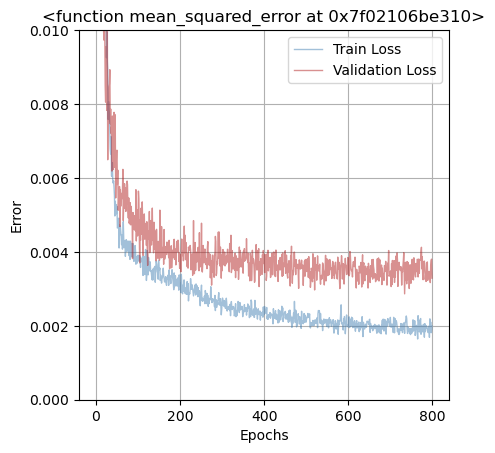

In [ ]:
fig, ax = plt.subplots()

for i in range(k_folds * n_CVrepeats):

    # ax.plot(train_loss[i], linewidth=1, color='steelblue', alpha = 0.5)
    # ax.plot(val_loss[i],   linewidth=1, color='firebrick', alpha = 0.5)

    if i == 5:
        ax.plot(train_loss[i], label=f"Train Loss",
                linewidth=1, color='steelblue', alpha=0.5)
        ax.plot(val_loss[i],   label=f"Validation Loss",
                linewidth=1, color='firebrick', alpha=0.5)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title(loss_func)
ax.legend()
ax.grid()
ax.set_box_aspect(1)
ax.set_ylim(0, 0.01)
plt.savefig('NNHonly_RepeatedKFold_loss.png', format='png', dpi=200)
plt.show()

## Evaluate the training results

#### Show the model.h5 files in this directory


In [ ]:
import os
dir_path = os.getcwd()

# list all files in the directory
files = os.listdir(dir_path)

# loop through all files and print only .h5 files
for file in files:
    if file.endswith('.h5') and file.startswith('NNHonly_model_RepeatedKFold'):
        print(file)

NNHonly_model_RepeatedKFold_5.h5
NNHonly_model_RepeatedKFold_11.h5
NNHonly_model_RepeatedKFold_7.h5
NNHonly_model_RepeatedKFold_4.h5
NNHonly_model_RepeatedKFold_1.h5
NNHonly_model_RepeatedKFold_2.h5
NNHonly_model_RepeatedKFold_6.h5
NNHonly_model_RepeatedKFold_9.h5
NNHonly_model_RepeatedKFold_3.h5
NNHonly_model_RepeatedKFold_12.h5
NNHonly_model_RepeatedKFold_8.h5
NNHonly_model_RepeatedKFold_10.h5


### Check the training quality

remember now we have MC dropout and the prediction now is stochastic


In [ ]:
# # -----------------------------------
# # compute the repeated model prediction - only validation data
# # -----------------------------------

# H1_test_pred_X1_mean = []
# H1_test_pred_X1_std  = []
# for i in range(k_folds * n_CVrepeats):

#     # ----- load the model for prediction -----
#     NNHonly_model_loaded_temp = keras.models.load_model(f'NNHonly_model_RepeatedKFold_{i+1}.h5')
#     # -----------------------------------------


#     # ----- model prediction + uncertainty by MC dropout -----
#     mc_repeat = 50

#     H1_test_pred_X1_stack_temp = np.stack([scaler_output.inverse_transform(
#                                   NNHonly_model_loaded_temp.predict([scaler_compo.transform(X1_test_KFold[i]),
#                                                                 scaler_H_specific.transform(Y1_test_KFold[i])],
#                                                                 verbose = 0)) for sample in range(mc_repeat)])

#     H1_test_pred_X1_mean.append(np.mean(H1_test_pred_X1_stack_temp, axis = 0).reshape((-1,)))
#     H1_test_pred_X1_std.append(np.std(H1_test_pred_X1_stack_temp,  axis = 0).reshape((-1,)))
#     # -----------------------------------------

In [ ]:
import tensorflow as tf

H1_test_pred_X1_mean = []
H1_test_pred_X1_std = []
mc_repeat = 50


def predict_one_model(i):
    NNHonly_model_loaded_temp = keras.models.load_model(
        f'NNHonly_model_RepeatedKFold_{i+1}.h5')

    def predict_one_sample():
        return scaler_output.inverse_transform(
            NNHonly_model_loaded_temp.predict(
                [scaler_compo.transform(
                    X1_test_KFold[i]), scaler_H_specific.transform(Y1_test_KFold[i])],
                verbose=0)
        )

    H1_test_pred_X1_stack_temp = tf.map_fn(
        lambda _: predict_one_sample(),
        tf.range(mc_repeat),
        dtype=tf.float32,
        parallel_iterations=mc_repeat
    )

    H1_test_pred_X1_mean_temp = np.mean(
        H1_test_pred_X1_stack_temp, axis=0).reshape((-1,))
    H1_test_pred_X1_std_temp = np.std(
        H1_test_pred_X1_stack_temp,  axis=0).reshape((-1,))

    return H1_test_pred_X1_mean_temp, H1_test_pred_X1_std_temp


results = Parallel(n_jobs=-1)(
    delayed(predict_one_model)(i) for i in range(k_folds * n_CVrepeats)
)

for mean, std in results:
    H1_test_pred_X1_mean.append(mean)
    H1_test_pred_X1_std.append(std)

2023-03-10 16:10:27.026986: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:27.049854: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:27.071627: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:27.077947: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:27.097970: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been r

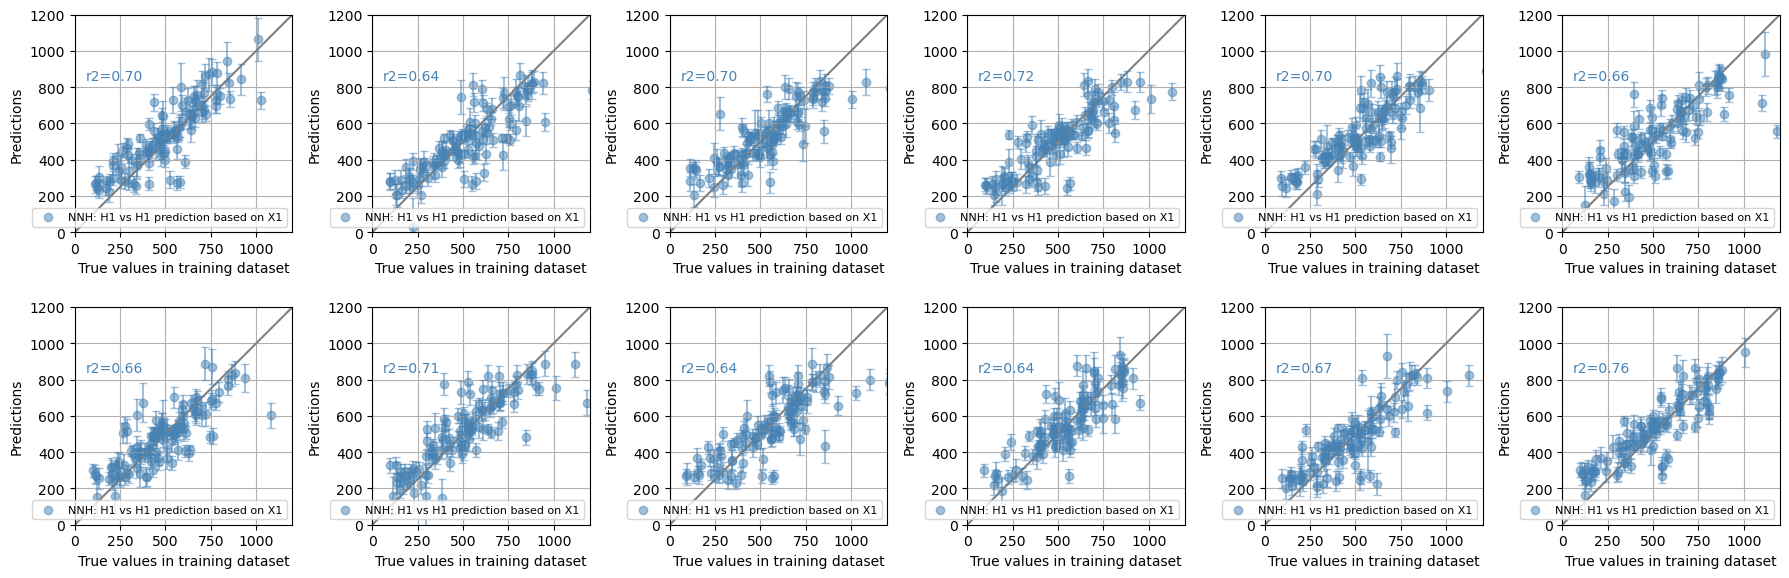

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(18, 6))
for i in range(k_folds * n_CVrepeats):
    # ----- plot true vs prediction -----
    lims = [0, 1200]
    row_idx = i // 6
    col_idx = i % 6
    axs[row_idx, col_idx].set_xlim(lims)
    axs[row_idx, col_idx].set_ylim(lims)
    axs[row_idx, col_idx].plot(lims, lims, color='grey')
    axs[row_idx, col_idx].scatter(H1_test_KFold[i], H1_test_pred_X1_mean[i],
                                  label='NNH: H1 vs H1 prediction based on X1',
                                  color='steelblue', alpha=0.5)
    axs[row_idx, col_idx].errorbar(x=H1_test_KFold[i], y=H1_test_pred_X1_mean[i], yerr=H1_test_pred_X1_std[i],
                                   fmt='none', ecolor='steelblue', capsize=3, alpha=0.5)

    r = r2_score(H1_test_KFold[i], H1_test_pred_X1_mean[i])
    axs[row_idx, col_idx].text(.05, .7, 'r2={:.2f}'.format(
        r), transform=axs[row_idx, col_idx].transAxes, color='steelblue')
    axs[row_idx, col_idx].set_xlabel('True values in training dataset')
    axs[row_idx, col_idx].set_ylabel('Predictions')
    axs[row_idx, col_idx].set_aspect('equal', 'box')
    axs[row_idx, col_idx].legend(loc=4, prop={'size': 8})
    axs[row_idx, col_idx].grid()

# adjust spacing and show plot
fig.tight_layout()
plt.savefig('NNHonly_RepeatedKFold_True_Prediction_individual.png',
            bbox_inches='tight')
plt.show()

In [ ]:
# # -----------------------------------
# # compute the repeated model prediction - training+validation data
# # -----------------------------------

# H1_pred_X1_stack = np.empty((0, X1.shape[0], 1))

# for i in range(k_folds * n_CVrepeats):

#     # ----- load the model for prediction -----
#     NNHonly_model_loaded_temp = keras.models.load_model(f'NNHonly_model_RepeatedKFold_{i+1}.h5')
#     # -----------------------------------------


#     # ----- model prediction + uncertainty by MC dropout -----
#     mc_repeat = 50

#     H1_pred_X1_stack_temp = np.stack([scaler_output.inverse_transform(
#                                      NNHonly_model_loaded_temp.predict([scaler_compo.transform(X1),
#                                                                         scaler_H_specific.transform(Y1)],
#                                                                         verbose = 0)) for sample in range(mc_repeat)])

#     H1_pred_X1_mean  = np.mean(H1_pred_X1_stack_temp, axis = 0).reshape((-1,))
#     H1_pred_X1_std   = np.std(H1_pred_X1_stack_temp,  axis = 0).reshape((-1,))

#     # stack
#     print(H1_pred_X1_stack_temp.shape)
#     H1_pred_X1_stack = np.concatenate((H1_pred_X1_stack, H1_pred_X1_stack_temp), axis=0)
#     # -----------------------------------------

# # ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
# print(H1_pred_X1_stack.shape)
# H1_pred_X1_KFold_mean = np.mean(H1_pred_X1_stack, axis=0).reshape(-1)
# H1_pred_X1_KFold_std = np.std(H1_pred_X1_stack, axis=0).reshape(-1)

# print(H1_pred_X1_KFold_mean.shape, H1_pred_X1_KFold_std.shape)

In [ ]:
H1_pred_X1_stack = np.empty((0, X1.shape[0], 1))
mc_repeat = 50

# Define a function to predict for one model and one MC sample


def predict_one_model(i):
    # Load the model for prediction
    NNHonly_model_loaded_temp = keras.models.load_model(
        f'NNHonly_model_RepeatedKFold_{i+1}.h5')

    # Define a function to compute one MC sample
    def predict_one_sample():
        return scaler_output.inverse_transform(
            NNHonly_model_loaded_temp.predict(
                [scaler_compo.transform(X1), scaler_H_specific.transform(Y1)],
                verbose=0)
        )

    # Use TensorFlow to parallelize the MC dropout
    H1_pred_X1_stack_temp = tf.map_fn(
        lambda _: predict_one_sample(),
        tf.range(mc_repeat),
        dtype=tf.float32,
        parallel_iterations=mc_repeat
    )

    print(H1_pred_X1_stack_temp.shape)
    return H1_pred_X1_stack_temp.numpy()


# Parallelize the for loop over the models
H1_pred_X1_stack_list = Parallel(n_jobs=-1)(
    delayed(predict_one_model)(i) for i in range(k_folds * n_CVrepeats)
)

# Stack the predictions
H1_pred_X1_stack = np.concatenate(H1_pred_X1_stack_list, axis=0)

# Plot true vs prediction for all the RepeatedKFold + MC_dropout
H1_pred_X1_KFold_mean = np.mean(H1_pred_X1_stack, axis=0).reshape(-1)
H1_pred_X1_KFold_std = np.std(H1_pred_X1_stack, axis=0).reshape(-1)

print(H1_pred_X1_KFold_mean.shape, H1_pred_X1_KFold_std.shape)

2023-03-10 16:10:42.223532: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:42.239723: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:42.264105: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:42.264688: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 16:10:42.283738: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been r

KeyboardInterrupt: 

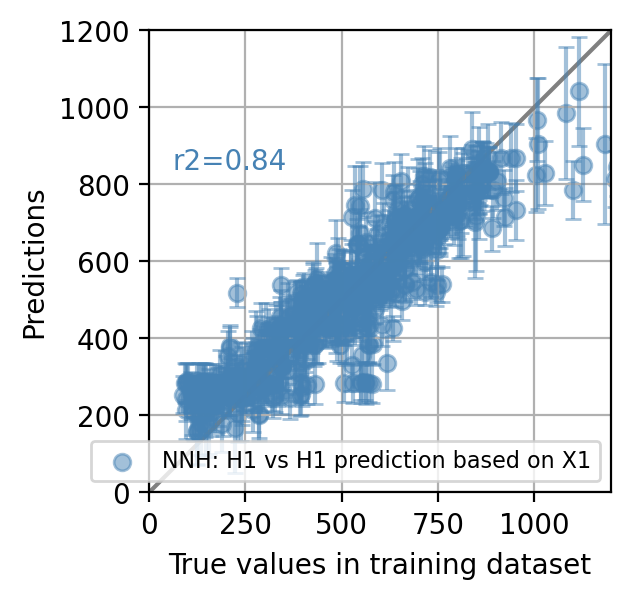

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), dpi=200)
lims = [0, 1200]
axs.set_xlim(lims)
axs.set_ylim(lims)
axs.plot(lims, lims, color='grey')
axs.scatter(H1, H1_pred_X1_KFold_mean,
            label='NNH: H1 vs H1 prediction based on X1',
            color='steelblue', alpha=0.5)
axs.errorbar(x=H1, y=H1_pred_X1_KFold_mean, yerr=H1_pred_X1_KFold_std,
             fmt='none', ecolor='steelblue', capsize=3, alpha=0.5)

r = r2_score(H1, H1_pred_X1_KFold_mean)
axs.text(.05, .7, 'r2={:.2f}'.format(r),
         transform=axs.transAxes, color='steelblue')
axs.set_xlabel('True values in training dataset')
axs.set_ylabel('Predictions')
axs.set_aspect('equal', 'box')
axs.legend(loc=4, prop={'size': 8})
axs.grid()
plt.savefig('NNHonly_RepeatedKFold_True_Prediction_AVG.png',
            bbox_inches='tight')
plt.show()

## Make predictions

#### Load the inputs for making predictions


In [ ]:
# NNC_model_loaded.get_config()


# ----- import the new dataset -----
print('----------------------------------')
print('----- import the new dataset -----')
print('----------------------------------')
# df_new_at = pd.read_excel(data_path + 'MultiTaskModel_corrosion_PT1_KW131_at_pct.xlsx')
# df_new_wt = pd.read_excel(data_path + 'MultiTaskModel_corrosion_PT1_KW131_wt_pct.xlsx')
# vars_ele  = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
# KW_name = 'KW131'

df_new_at = pd.read_excel(
    data_path + 'MultiTaskModel_hardness_PT3_KW99_at_pct.xlsx')
df_new_wt = pd.read_excel(
    data_path + 'MultiTaskModel_hardness_PT3_KW99_wt_pct.xlsx')
vars_ele = ['Fe', 'Cr', 'Ni', 'Co', 'V']
KW_name = 'KW99'

display(df_new_at.head(1))
display(df_new_wt.head(1))


# ----- get the `df_compo_new` ------
print('-----------------------------------')
print('----- get the `df_compo_new` ------')
print('-----------------------------------')
df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
                                 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

df_compo_new = pd.concat(
    [df_compo, df_new_wt[vars_ele]], axis=0, ignore_index=True)
df_compo_new = df_compo_new.fillna(0)  # fill in the nan by zero
display(df_compo_new.head(1))

compo_new = np.asarray(df_compo_new.values)


# ----- get the `df_H_specific_new` -----
print('---------------------------------------')
print('----- get the `df_H_specific_new` ------')
print('---------------------------------------')
df_H_specific_new = df_new_at[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]
display(df_H_specific_new.head(1))
H_specific_new = np.asarray(df_H_specific_new.values)


# ----- get the `df_C_specifi_new` -----
print('---------------------------------------')
print('----- get the `df_C_specifi_new` ------')
print('---------------------------------------')
# TestTemperature_C, ChlorideIonConcentration, pH, ScanRate_mVs
C_testing = np.array([25, 0.5, 7, 0.215])
# corrosion testing condition array
C_specific_new = np.ones(
    (len(df_compo_new. index), input3_C_specific_shape[0])) * C_testing

df_C_specific_new = pd.DataFrame(C_specific_new, columns=[
                                 'TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs'])
display(df_C_specific_new.head(1))

----------------------------------
----- import the new dataset -----
----------------------------------


,Index,Ni,Cr,Co,V,Fe,FORMULA,delta_a,Hmix,VEC,sigma_bulk_modulus
0,0,49.6,33.7,4.61,1.76,10.3,Ni49.6 Cr33.7 Co4.61 V1.76 Fe10.3,0.007568,-6.271306,8.311393,9.283274


,Index,Ni,Cr,Co,V,Fe
0,0,51.985556,31.290494,4.851446,1.601018,10.271486


-----------------------------------
----- get the `df_compo_new` ------
-----------------------------------


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,Cu,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf
0,10.271486,31.290494,51.985556,0,0,0,0,0,0,0,0,0,1.601018,0,0,4.851446,0,0,0,0


---------------------------------------
----- get the `df_H_specific_new` ------
---------------------------------------


,delta_a,Hmix,VEC,sigma_bulk_modulus
0,0.007568,-6.271306,8.311393,9.283274


---------------------------------------
----- get the `df_C_specifi_new` ------
---------------------------------------


,TestTemperature_C,ChlorideIonConcentration,pH,ScanRate_mVs
0,25.0,0.5,7.0,0.215


In [ ]:
# load the wafer-coordinates
df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
index_PVD_x_y = df_PVD_x_y.index.values+1

In [ ]:
# H1_new_pred_mean = []
# H1_new_pred_std  = []

# H1_new_pred_stack = np.empty((0, len(compo_new), 1))

# for i in range(k_folds * n_CVrepeats):

#     # ----- load the model for prediction -----
#     NNHonly_model_loaded_temp = keras.models.load_model(f'NNHonly_model_RepeatedKFold_{i+1}.h5')
#     # -----------------------------------------


#     # ----- model prediction + uncertainty by MC dropout -----
#     mc_repeat = 100

#     H1_new_pred_stack_temp = np.stack([scaler_output.inverse_transform(
#                                        NNHonly_model_loaded_temp.predict([scaler_compo.transform(compo_new),
#                                                                           scaler_H_specific.transform(H_specific_new)],
#                                                                           verbose = 0)) for sample in range(mc_repeat)])

#     H1_new_pred_mean_temp = np.mean(H1_new_pred_stack_temp, axis = 0).reshape((-1,))
#     H1_new_pred_std_temp  = np.std(H1_new_pred_stack_temp,  axis = 0).reshape((-1,))

#     H1_new_pred_mean.append(H1_new_pred_mean_temp)
#     H1_new_pred_std.append(H1_new_pred_std_temp)

#     # stack
#     print(H1_new_pred_stack_temp.shape)
#     H1_new_pred_stack = np.concatenate((H1_new_pred_stack, H1_new_pred_stack_temp), axis=0)
#     # -----------------------------------------

In [ ]:
H1_new_pred_mean = []
H1_new_pred_std = []

H1_new_pred_stack = np.empty((0, len(compo_new), 1))

# Define a function to predict for one model and one MC sample


def predict_one_model(i):
    # Load the model for prediction
    NNHonly_model_loaded_temp = keras.models.load_model(
        f'NNHonly_model_RepeatedKFold_{i+1}.h5')

    # Define a function to compute one MC sample
    def predict_one_sample():
        return scaler_output.inverse_transform(
            NNHonly_model_loaded_temp.predict(
                [scaler_compo.transform(
                    compo_new), scaler_H_specific.transform(H_specific_new)],
                verbose=0)
        )

    # Use TensorFlow to parallelize the MC dropout
    H1_new_pred_stack_temp = tf.map_fn(
        lambda _: predict_one_sample(),
        tf.range(100),
        dtype=tf.float32,
        parallel_iterations=100
    )

    H1_new_pred_mean_temp = np.mean(
        H1_new_pred_stack_temp, axis=0).reshape((-1,))
    H1_new_pred_std_temp = np.std(
        H1_new_pred_stack_temp,  axis=0).reshape((-1,))

    # stack
    print(H1_new_pred_stack_temp.shape)
    return H1_new_pred_stack_temp.numpy(), H1_new_pred_mean_temp, H1_new_pred_std_temp


# Parallelize the for loop over the models
H1_new_pred_stack_list = Parallel(n_jobs=-1)(
    delayed(predict_one_model)(i) for i in range(k_folds * n_CVrepeats)
)

# Stack the predictions
for H1_new_pred_stack_temp, H1_new_pred_mean_temp, H1_new_pred_std_temp in H1_new_pred_stack_list:
    H1_new_pred_stack = np.concatenate(
        (H1_new_pred_stack, H1_new_pred_stack_temp), axis=0)
    H1_new_pred_mean.append(H1_new_pred_mean_temp)
    H1_new_pred_std.append(H1_new_pred_std_temp)

# Print the shapes of the outputs
print(H1_new_pred_stack.shape)
print(len(H1_new_pred_mean))
print(len(H1_new_pred_std))

2023-03-10 09:39:37.706782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 09:39:37.721408: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 09:39:37.734428: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 09:39:37.746453: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 09:39:37.767277: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been r

(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(100, 69, 1)
(1200, 69, 1)
12
12


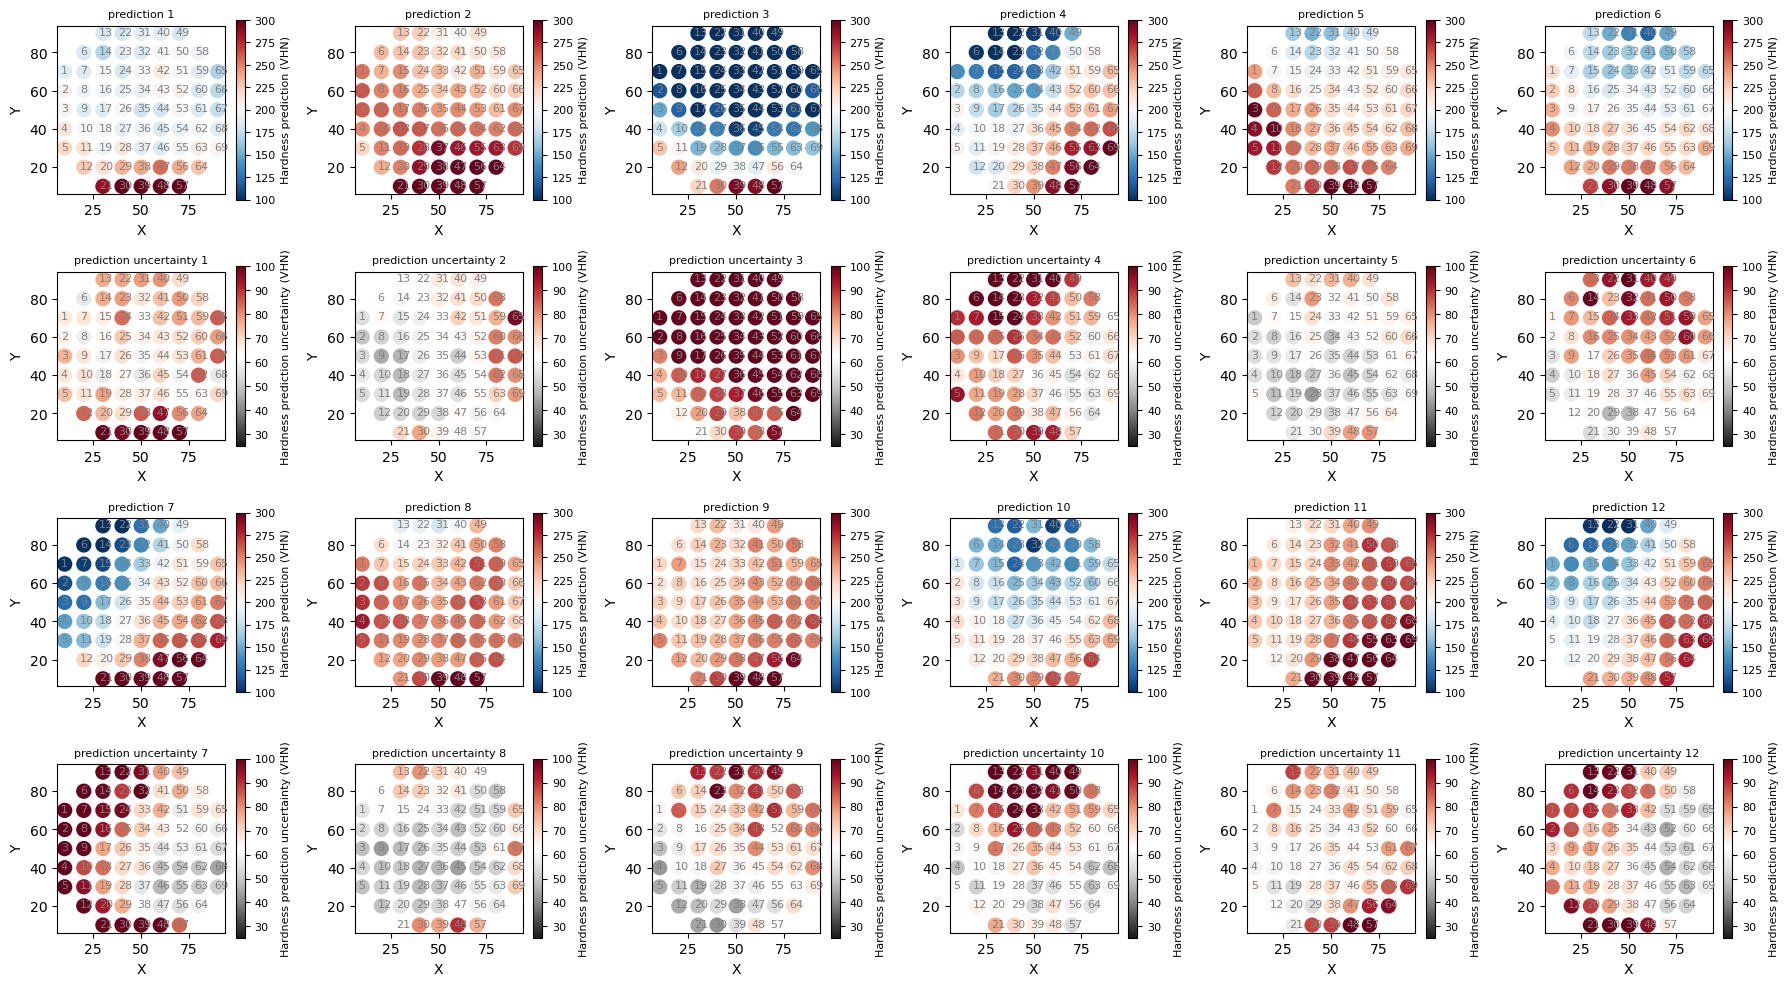

In [ ]:
# plot prediction and uncertainty on wafer-coordinates
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10))

for i in range(k_folds * n_CVrepeats):

    # ----- prepare the (row, col) for each subplot -----
    row_pred_idx = i // 6
    col_pred_idx = i % 6
    if i+1 > 6:
        row_pred_idx = i // 6 + 1

    row_unc_idx = i // 6 + 1
    col_unc_idx = i % 6
    if i+1 > 6:
        row_unc_idx = i // 6 + 2

    # print(f'pred {i+1}: x={row_pred_idx:.0f} y={col_pred_idx:.0f}')
    # print(f'unc  {i+1}: x={row_unc_idx:.0f} y={col_unc_idx:.0f}')
    # -----------------------------------

    # ----- subplot 1 prediction -----
    cax1 = axs[row_pred_idx, col_pred_idx].scatter(
        coord_x, coord_y, c=H1_new_pred_mean[i], s=400, marker='.', cmap='RdBu_r', vmin=100, vmax=300)
    axs[row_pred_idx, col_pred_idx].set_xlabel('X')
    axs[row_pred_idx, col_pred_idx].set_ylabel('Y')
    axs[row_pred_idx, col_pred_idx].set_title(f'prediction {i+1}', fontsize=8)
    axs[row_pred_idx, col_pred_idx].set_aspect('equal', 'box')
    for i_pvd, txt in enumerate(index_PVD_x_y):
        axs[row_pred_idx, col_pred_idx].annotate(
            txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1, fontsize=8)

    cbar1 = fig.colorbar(cax1, ax=axs[row_pred_idx, col_pred_idx])
    cbar1.set_label('Hardness prediction (VHN)', size=8)
    cbar1.ax.tick_params(labelsize=8)

    # ----- subplot 2 prediction uncertainty -----
    cax2 = axs[row_unc_idx, col_unc_idx].scatter(
        coord_x, coord_y, c=H1_new_pred_std[i], s=400, marker='.', cmap='RdGy_r', vmin=25, vmax=100)
    axs[row_unc_idx, col_unc_idx].set_xlabel('X')
    axs[row_unc_idx, col_unc_idx].set_ylabel('Y')
    axs[row_unc_idx, col_unc_idx].set_title(
        f'prediction uncertainty {i+1}', fontsize=8)
    axs[row_unc_idx, col_unc_idx].set_aspect('equal', 'box')
    for i, txt in enumerate(index_PVD_x_y):
        axs[row_unc_idx, col_unc_idx].annotate(
            txt, (coord_x[i]-2, coord_y[i]-1), color="grey", alpha=1, fontsize=8)

    cbar2 = fig.colorbar(cax2, ax=axs[row_unc_idx, col_unc_idx])
    cbar2.set_label('Hardness prediction uncertainty (VHN)', size=8)
    cbar2.ax.tick_params(labelsize=8)
    # -----------------------------------

# adjust spacing and show plot
fig.tight_layout()
plt.savefig('NNHonly_RepeatedKFold_prediction_uncertainty_individual_' +
            KW_name + '.png', bbox_inches='tight')
plt.show()

(1200, 69, 1)
(69,) (69,)


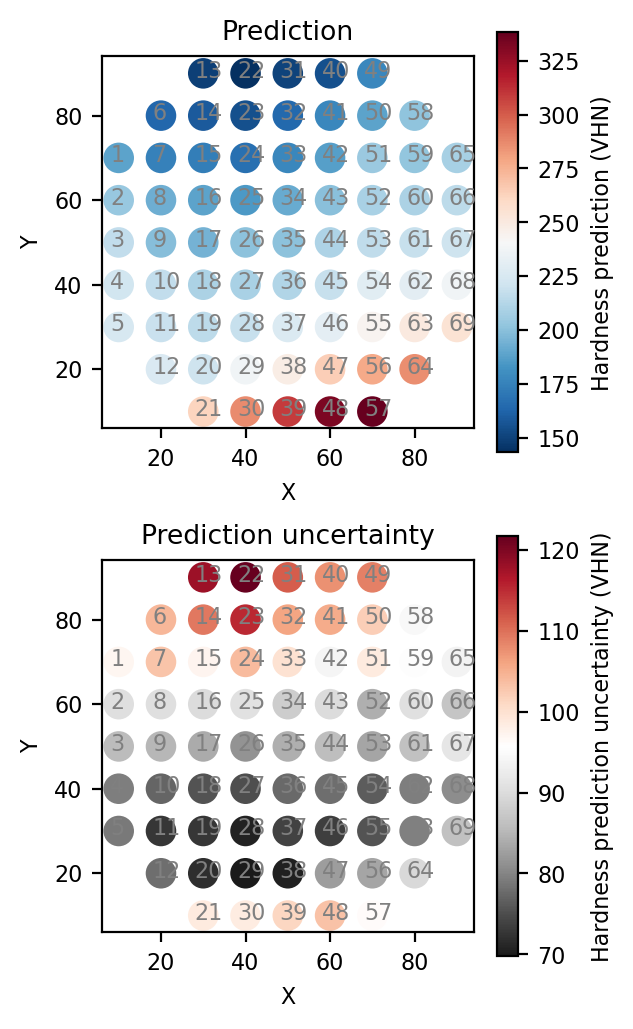

In [ ]:
# ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
print(H1_new_pred_stack.shape)
H1_new_pred_KFold_mean = np.mean(H1_new_pred_stack, axis=0).reshape(-1)
H1_new_pred_KFold_std = np.std(H1_new_pred_stack, axis=0).reshape(-1)

print(H1_new_pred_KFold_mean.shape, H1_new_pred_KFold_std.shape)


# Set font size for all text in figure
plt.rcParams.update({'font.size': 8})

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 6), dpi=200)

# Subplot 1: Prediction
cmap = plt.get_cmap('RdBu_r')
cax1 = ax1.scatter(coord_x, coord_y, c=H1_new_pred_KFold_mean,
                   s=400, marker='.', cmap=cmap)  # , vmin=0, vmax=900)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Prediction')
ax1.set_aspect('equal')
for i_pvd, txt in enumerate(index_PVD_x_y):
    ax1.annotate(
        txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1)

cbar1 = fig.colorbar(cax1, ax=ax1)
cbar1.set_label('Hardness prediction (VHN)')

# Subplot 2: Prediction uncertainty
cmap = plt.get_cmap('RdGy_r')
cax2 = ax2.scatter(coord_x, coord_y, c=H1_new_pred_KFold_std,
                   s=400, marker='.', cmap=cmap)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Prediction uncertainty')
ax2.set_aspect('equal')
for i_pvd, txt in enumerate(index_PVD_x_y):
    ax2.annotate(
        txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1)

cbar2 = fig.colorbar(cax2, ax=ax2)
cbar2.set_label('Hardness prediction uncertainty (VHN)')

# Save and show figure
plt.savefig('NNHonly_RepeatedKFold_prediction_uncertainty_AVG_' +
            KW_name + '.png', bbox_inches='tight')
plt.show()